In [2]:
import pandas as pd
# teste
df = pd.read_csv("SMSSpamCollection", sep="\t", header=None, names=["Label", "Message"])
# header - cabecalho (None, nao tem cabecalho) #sep \t por se tratar de um arquivo tsv
display(df) #df = data frame


,Label,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


Label
ham     4825
spam     747
Name: count, dtype: int64


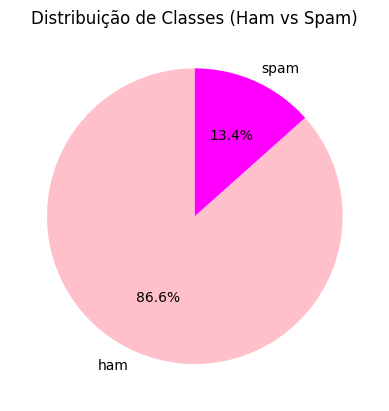

In [3]:
import matplotlib.pyplot as plt

contagem = df['Label'].value_counts()
print(contagem)
contagem.plot(kind='pie', autopct='%1.1f%%', colors=["pink", "magenta"], title="Distribuição de Classes (Ham vs Spam)", startangle=90, legend=False)
plt.ylabel('')
plt.show()

,Label,Message,Word_count
0,ham,"Go until jurong point, crazy.. Available only ...",20
1,ham,Ok lar... Joking wif u oni...,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28
3,ham,U dun say so early hor... U c already then say...,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",13
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,30
5568,ham,Will ü b going to esplanade fr home?,8
5569,ham,"Pity, * was in mood for that. So...any other s...",10
5570,ham,The guy did some bitching but I acted like i'd...,26


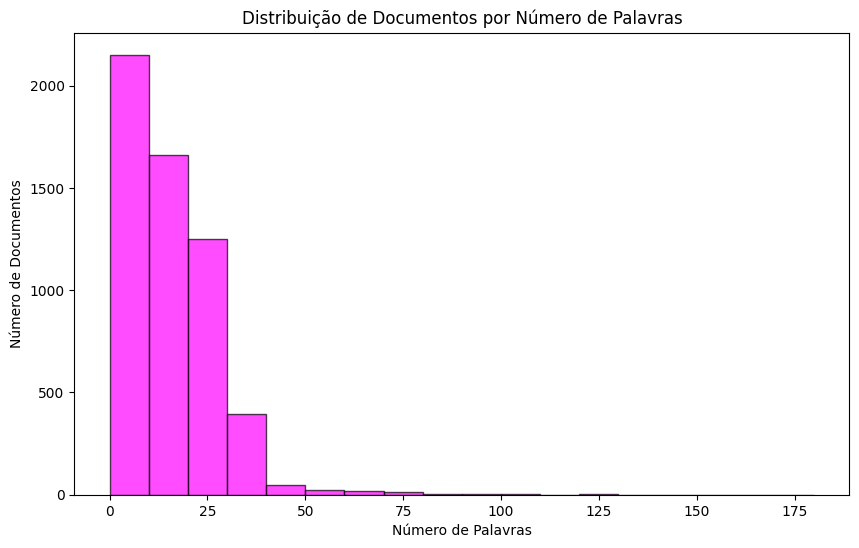

In [4]:
df["Word_count"] = df["Message"].apply(lambda x: len(x.split())) # Número de palavras por documento
# Split divide o texto em palavras usando espaço como separador
display(df)

plt.figure(figsize=(10,6))
plt.hist(df["Word_count"], bins=range(0, df["Word_count"].max() + 10, 10), edgecolor='black', color='magenta', alpha=0.7)

plt.title("Distribuição de Documentos por Número de Palavras")
plt.xlabel("Número de Palavras")
plt.ylabel("Número de Documentos")

plt.show()

In [5]:
df["Word_count"].describe() #Alguns dados
# Count: número de mensagens
# Mean: média de palavras por mensagem
# Std: desvio padrão (o quanto as mensagens variam em relação à média)
# Min: a menor mensagem tem uma palavra
# 25%: 25% das mensagens têm até 7 palavras
# Max: a maior mensagem tem 171 palavras

count    5572.000000
mean       15.597452
std        11.404053
min         1.000000
25%         7.000000
50%        12.000000
75%        23.000000
max       171.000000
Name: Word_count, dtype: float64

In [6]:
#Iniciando pré-processamento de Dados (Passo 2)

#Passo 1 - Converter para minúsculas, remover acentuação, e stopwords
import nltk
import unicodedata
from nltk.corpus import stopwords

nltk.download('stopwords') #Lista de stopwords

# stopwords_pt = set(stopwords.words('portuguese')) # Lista em português

stopwords_en = set(stopwords.words('english')) # Lista em português


def processar_etapa1(texto):
    texto = texto.lower() # Coloca tudo em minúsculo
    
    # remove acentuação
    texto = ''.join( # depois de filtrar, junta tudo de novo em uma string normal
        caractere for caractere in unicodedata.normalize('NFD', texto) # Quebra os caracteres acentuados (ex.: ç = c, cedilha)
        if unicodedata.category(caractere) != 'Mn' # Mn = Mark, Nonspacing (acentos, tils, cedilhas...)
    )

    tokens = texto.split() # quebra em tokens
    tokens = [t for t in tokens if t not in stopwords_en]

    return ' '.join(tokens) # junta novamente em uma string

df["Message_clean"] = df["Message"].apply(processar_etapa1)
display(df)

[nltk_data] Downloading package stopwords to /home/ester/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Label,Message,Word_count,Message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,"go jurong point, crazy.. available bugis n gre..."
1,ham,Ok lar... Joking wif u oni...,6,ok lar... joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,11,u dun say early hor... u c already say...
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,"nah think goes usf, lives around though"
...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,30,2nd time tried 2 contact u. u £750 pound prize...
5568,ham,Will ü b going to esplanade fr home?,8,u b going esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s...",10,"pity, * mood that. so...any suggestions?"
5570,ham,The guy did some bitching but I acted like i'd...,26,guy bitching acted like interested buying some...


In [7]:
# Passo 2 - Remoção de marcações
import re
df["Message_clean"] = df["Message_clean"].apply(lambda x: re.sub(r"[@#][\w@]+", "", x))
# r"[@#]\w+" -> busca o que deve ser removido
# "" -> o que deve ser substituído (nada)
display(df)


,Label,Message,Word_count,Message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,"go jurong point, crazy.. available bugis n gre..."
1,ham,Ok lar... Joking wif u oni...,6,ok lar... joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,11,u dun say early hor... u c already say...
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,"nah think goes usf, lives around though"
...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,30,2nd time tried 2 contact u. u £750 pound prize...
5568,ham,Will ü b going to esplanade fr home?,8,u b going esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s...",10,"pity, * mood that. so...any suggestions?"
5570,ham,The guy did some bitching but I acted like i'd...,26,guy bitching acted like interested buying some...


In [8]:
# Passo 4: remover urls (http e www)

def remover_urls(texto):
    return re.sub(r'(http[s]?://\S+|www\.\S+)', '', texto, flags=re.IGNORECASE)
    # re.sub (padrao, substituo, texto)
    # http\S+ -> pega tudo que comeca com http e segue com qualquer coisa que nao seja espaço
    # www\.\S+ -> pega tudo que comeca com www. seguido pos algo que nao seja espaço

df["Message_clean"] = df["Message_clean"].apply(remover_urls)
display(df)

,Label,Message,Word_count,Message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,"go jurong point, crazy.. available bugis n gre..."
1,ham,Ok lar... Joking wif u oni...,6,ok lar... joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,11,u dun say early hor... u c already say...
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,"nah think goes usf, lives around though"
...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,30,2nd time tried 2 contact u. u £750 pound prize...
5568,ham,Will ü b going to esplanade fr home?,8,u b going esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s...",10,"pity, * mood that. so...any suggestions?"
5570,ham,The guy did some bitching but I acted like i'd...,26,guy bitching acted like interested buying some...


In [9]:
# Passo 3 - Reduzir repetições (máximo duas ocorrências)
# Exemplo: boaaaaaaa -> boaa

def reduzir_repeticoes(texto):
    return re.sub(r'(.)\1{2,}', r'\1\1', texto)
    # (.) -> captura qualquer caractere
    # \1 refere-se ao mesmo caractere capturado
    # {2,} -> casa com duas ou mais repetições do mesmo caractere
    # r'\1\1 -> substitui por duas ocorrencias desse caractere

df["Message_clean"] = df["Message_clean"].apply(reduzir_repeticoes)
display(df)


,Label,Message,Word_count,Message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,"go jurong point, crazy.. available bugis n gre..."
1,ham,Ok lar... Joking wif u oni...,6,ok lar.. joking wif u oni..
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,11,u dun say early hor.. u c already say..
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,"nah think goes usf, lives around though"
...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,30,2nd time tried 2 contact u. u £750 pound prize...
5568,ham,Will ü b going to esplanade fr home?,8,u b going esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s...",10,"pity, * mood that. so..any suggestions?"
5570,ham,The guy did some bitching but I acted like i'd...,26,guy bitching acted like interested buying some...


In [10]:
# Passo 5: remover pontuação

import string

df["Message_clean"] = df["Message_clean"].str.translate(str.maketrans('', '', string.punctuation))
display(df)

,Label,Message,Word_count,Message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,6,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,11,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah think goes usf lives around though
...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,30,2nd time tried 2 contact u u £750 pound prize ...
5568,ham,Will ü b going to esplanade fr home?,8,u b going esplanade fr home
5569,ham,"Pity, * was in mood for that. So...any other s...",10,pity mood that soany suggestions
5570,ham,The guy did some bitching but I acted like i'd...,26,guy bitching acted like interested buying some...


In [11]:

# Passo 6: remover entidades referentes à localizações e organizações
#Esse caso é para textos em inglês
"""
import spacy
nlp = spacy.load("en_core_web_sm")

entidades_para_remover = {"ORG", "GPE", "LOC"}

def remover_entidades(texto):
    doc = nlp(texto)
    indices_para_remover = set()
    
    for ent in doc.ents:
        if ent.label_ in entidades_para_remover:
            for token in ent:
                indices_para_remover.add(token.i)
    
    tokens_filtrados = [token.text for i, token in enumerate(doc) if i not in indices_para_remover]
    return " ".join(tokens_filtrados)

df["Message_clean"] = df["Message_clean"].apply(remover_entidades)
display(df)
"""

'\nimport spacy\nnlp = spacy.load("en_core_web_sm")\n\nentidades_para_remover = {"ORG", "GPE", "LOC"}\n\ndef remover_entidades(texto):\n    doc = nlp(texto)\n    indices_para_remover = set()\n    \n    for ent in doc.ents:\n        if ent.label_ in entidades_para_remover:\n            for token in ent:\n                indices_para_remover.add(token.i)\n    \n    tokens_filtrados = [token.text for i, token in enumerate(doc) if i not in indices_para_remover]\n    return " ".join(tokens_filtrados)\n\ndf["Message_clean"] = df["Message_clean"].apply(remover_entidades)\ndisplay(df)\n'

In [12]:
# Etapa 7: remover tokens numéricos

def remover_tokens_numericos(texto):
    tokens = texto.split()
    tokens_sem_numeros = [t for t in tokens if not re.search(r'\d', t)]
    return ' '.join(tokens_sem_numeros)

df["Message_clean"] = df["Message_clean"].apply(remover_tokens_numericos)
display(df)

,Label,Message,Word_count,Message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,6,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entry wkly comp win fa cup final tkts may...
3,ham,U dun say so early hor... U c already then say...,11,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah think goes usf lives around though
...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,30,time tried contact u u pound prize claim easy ...
5568,ham,Will ü b going to esplanade fr home?,8,u b going esplanade fr home
5569,ham,"Pity, * was in mood for that. So...any other s...",10,pity mood that soany suggestions
5570,ham,The guy did some bitching but I acted like i'd...,26,guy bitching acted like interested buying some...


In [13]:
# Etapa 8: remover palavras com menos de 3 caracteres

def remover_palavras_curtas(texto):
    tokens = texto.split()
    tokens_sem_palavras_curtas = [t for t in tokens if len(t) >= 3]
    return ' '.join(tokens_sem_palavras_curtas)

df["Message_clean"] = df["Message_clean"].apply(remover_palavras_curtas)
display(df)


,Label,Message,Word_count,Message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,jurong point crazy available bugis great world...
1,ham,Ok lar... Joking wif u oni...,6,lar joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entry wkly comp win cup final tkts may te...
3,ham,U dun say so early hor... U c already then say...,11,dun say early hor already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah think goes usf lives around though
...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,30,time tried contact pound prize claim easy call...
5568,ham,Will ü b going to esplanade fr home?,8,going esplanade home
5569,ham,"Pity, * was in mood for that. So...any other s...",10,pity mood that soany suggestions
5570,ham,The guy did some bitching but I acted like i'd...,26,guy bitching acted like interested buying some...


In [14]:
# Etapa 9: remover nomes pessoais
import spacy
nlp = spacy.load("en_core_web_sm")

def remover_nomes_pessoais(texto):
    doc = nlp(texto)
    texto_sem_nomes = [token.text for token in doc if token.ent_type_ != "PERSON"]
    return " ".join(texto_sem_nomes)

df["Message_clean"] = df["Message_clean"].apply(remover_nomes_pessoais)
display(df)


KeyboardInterrupt: 

In [ ]:
# Lematização

import spacy
nlp = spacy.load("en_core_web_sm")

def lematizacao(texto):
    doc = nlp(texto)
    tokens_lematizados = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return " ".join(tokens_lematizados)

df["Message_clean"] = df["Message_clean"].apply(lematizacao)
display(df)

sleep sleep


,Label,Message,Word_count,Message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,jurong point crazy available bugis great world...
1,ham,Ok lar... Joking wif u oni...,6,lar joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entry wkly comp win cup final tkts may te...
3,ham,U dun say so early hor... U c already then say...,11,dun say early hor already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah think goes usf lives around though
...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,30,time tried contact pound prize claim easy call...
5568,ham,Will ü b going to esplanade fr home?,8,going esplanade home
5569,ham,"Pity, * was in mood for that. So...any other s...",10,pity mood that soany suggestions
5570,ham,The guy did some bitching but I acted like i'd...,26,guy bitching acted like interested buying some...


,Label,Message,Word_count,Message_clean,Word_count_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,jurong point crazy available bugis great world...,12
1,ham,Ok lar... Joking wif u oni...,6,lar joking wif oni,4
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entry wkly comp win cup final tkts may te...,16
3,ham,U dun say so early hor... U c already then say...,11,dun say early hor already say,6
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah think goes usf lives around though,7
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,30,time tried contact pound prize claim easy call...,11
5568,ham,Will ü b going to esplanade fr home?,8,going esplanade home,3
5569,ham,"Pity, * was in mood for that. So...any other s...",10,pity mood that soany suggestions,5
5570,ham,The guy did some bitching but I acted like i'd...,26,guy bitching acted like interested buying some...,12


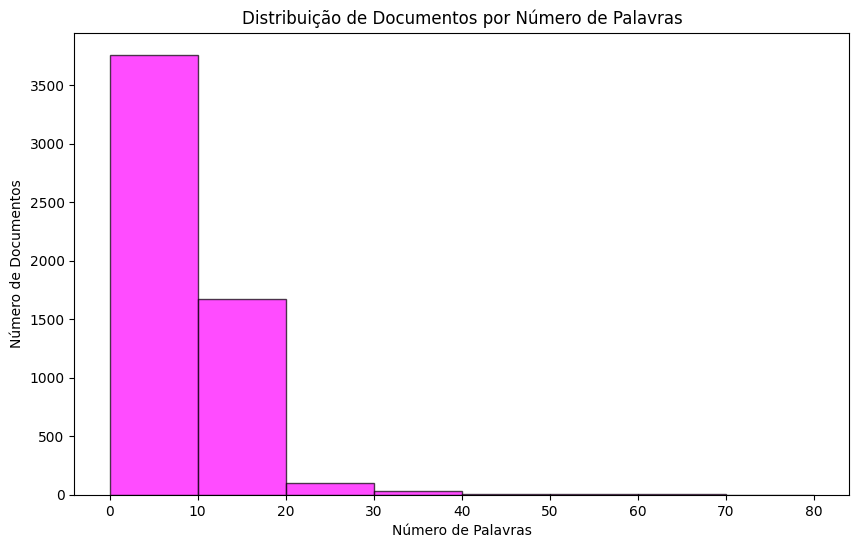

In [20]:
df["Word_count_clean"] = df["Message_clean"].apply(lambda x: len(x.split())) # Número de palavras por documento
# Split divide o texto em palavras usando espaço como separador
display(df)

plt.figure(figsize=(10,6))
plt.hist(df["Word_count_clean"], bins=range(0, df["Word_count_clean"].max() + 10, 10), edgecolor='black', color='magenta', alpha=0.7)

plt.title("Distribuição de Documentos por Número de Palavras")
plt.xlabel("Número de Palavras")
plt.ylabel("Número de Documentos")

plt.show()


In [21]:
# Passo 3: Representação TF-IDF 

X = df["Message_clean"] # Dados de entrada, matriz gerada pelo TfidfVectorizer
y = df["Label"] # Rótulos ham ou spam

from sklearn.preprocessing import LabelEncoder

codificador = LabelEncoder()
y_codificado = codificador.fit_transform(y) # Convertendo rótulos textuais para inteiros
# ham = 0, spam = 1

from sklearn.model_selection import train_test_split, GridSearchCV
# Dividindo em 80% treino e 20% teste

X_train, X_test, y_train, y_test = train_test_split(X, y_codificado, test_size=0.2, random_state=0)

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print("Vocabulário:", vectorizer.get_feature_names_out()[:20])
print(X_train_tfidf.toarray())

print(X_test_tfidf.toarray())

print("Número de linhas em tfidf2:", X_train_tfidf.shape)

Vocabulário: ['aah' 'aaniye' 'aaooright' 'aathilove' 'aathiwhere' 'abbey' 'abelu'
 'aberdeen' 'abi' 'ability' 'abiola' 'abj' 'able' 'about' 'abroad'
 'absence' 'abstract' 'abt' 'abta' 'aburo']
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Número de linhas em tfidf2: (4457, 7053)


Melhores parâmetros:  {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10}
Acurácia com os melhores parâmetros: 0.9632286995515695
F1 Score (macro) com os melhores parâmetros: 0.921266419693126


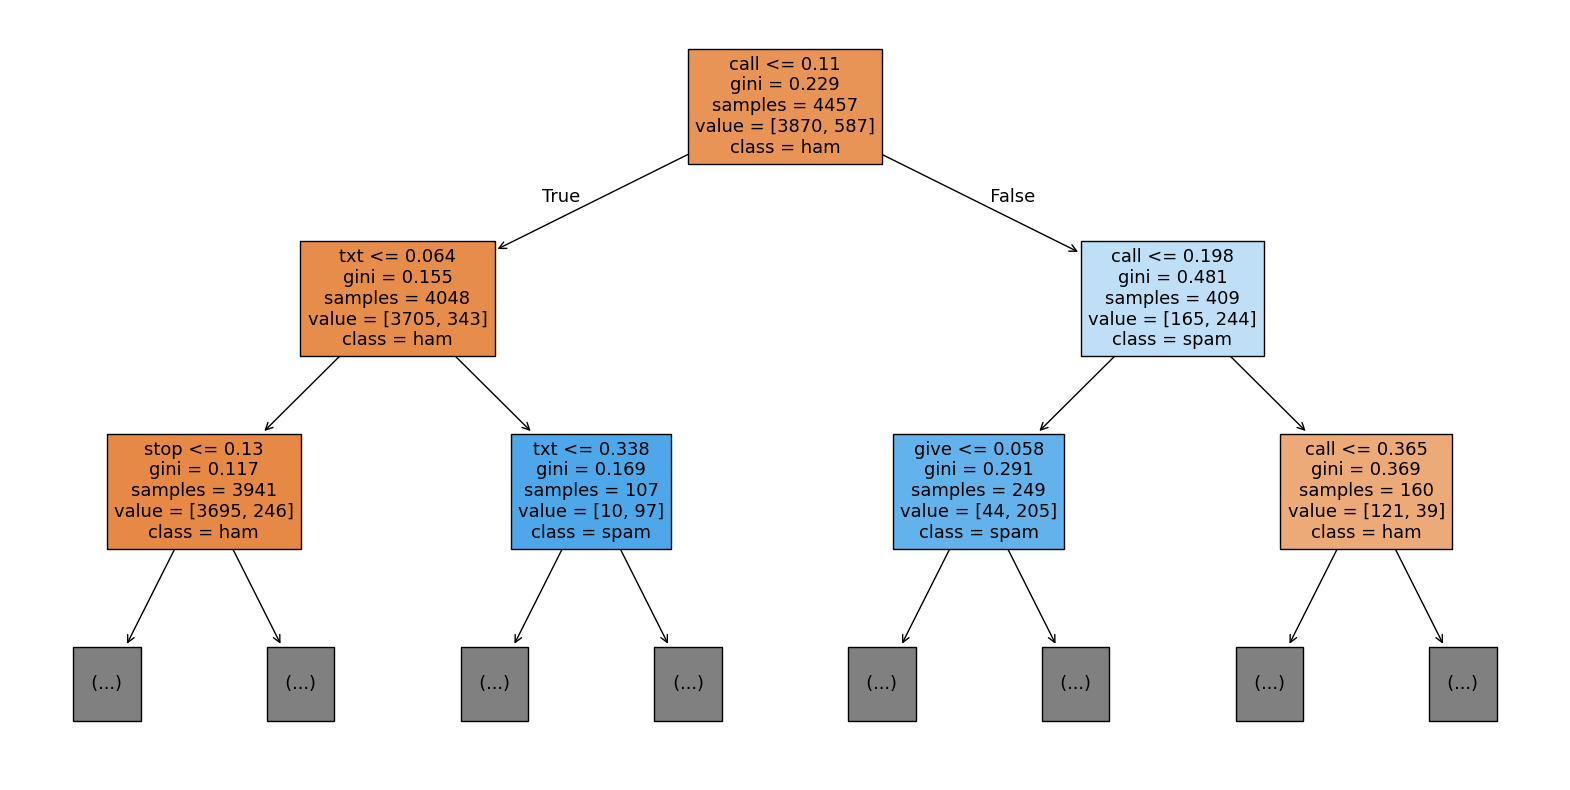

In [ ]:
# Passo 4 - Classificação
# Árvore de decisão

"""
X = tfidf # Dados de entrada, matriz gerada pelo TfidfVectorizer
y = df["Label"] # Rótulos ham ou spam

from sklearn.preprocessing import LabelEncoder

codificador = LabelEncoder()
y_codificado = codificador.fit_transform(y) # Convertendo rótulos textuais para inteiros
# ham = 0, spam = 1

from sklearn.model_selection import train_test_split, GridSearchCV
# Dividindo em 80% treino e 20% teste

X_train, X_test, y_train, y_test = train_test_split(X, y_codificado, test_size=0.2, random_state=0)
"""
parametros = {
    'criterion': ['gini', 'entropy'], # Função usada para medir a qualidade de uma divisão
    'max_depth': [None, 10, 20], # Profundidade máxima 
    'min_samples_split': [2, 5, 10], # Mínimo de amostras exigido para dividir um nó
    'min_samples_leaf': [1, 2, 4] # Mínimo de amostras exigido em um nó folha
}

from sklearn import tree
# Treinando a árvore de decisão

clf = tree.DecisionTreeClassifier()

grid_search = GridSearchCV(estimator=clf, param_grid=parametros, cv=5, scoring='accuracy')
#cv =5 significa que os dados sao divididos em 5 partes. O modelo é treinado 5 vezes, utilizando 4 partes
# para treino.

grid_search.fit(X_train_tfidf, y_train) # Treina o modelo utilizando os melhores parametros encontrados

print("Melhores parâmetros: ", grid_search.best_params_)

melhor_clf = grid_search.best_estimator_ # treina novamente com os melhores parametros

y_pred = melhor_clf.predict(X_test_tfidf) # Fazendo a previsão no conjunto de teste

from sklearn.metrics import accuracy_score, f1_score

acuracia = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')

print(f"Acurácia com os melhores parâmetros: {acuracia}")
print(f"F1 Score (macro) com os melhores parâmetros: {f1_macro}")

import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
tree.plot_tree(melhor_clf, max_depth=2, feature_names=vectorizer.get_feature_names_out(), class_names=codificador.classes_, filled=True)
plt.show()
# max_depth profundidade da árvore
# filled=True colore os nós de acordo com a classe predominante
# feature_names mostra quais palavras sao mais importantes para as decisoes


In [ ]:
# Explicando a árvore exibida
# call <= 0.108 Critério de divisão: se a frequência da palavra "call" for menor ou igual a 0.108 vai para a esquerda (mais provável ser ham)
# gini = 0.229 Medida de impureza do nó. Quanto menor, mais concentrado em uma única classe.
# samples = 4457 Quantidade de mensagens analisadas nese nó
# value = [3870, 587] 3870 são ham e 587 são spam

# Laranja: a classe predominante é ham, Azul: spam. Quanto mais intensa a cor, contém mais exemplos da mesma classe

Melhores parâmetros:  {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
Acurácia com os melhores parâmetros: 0.9551569506726457
F1 Score (macro) com os melhores parâmetros: 0.8946523053665911


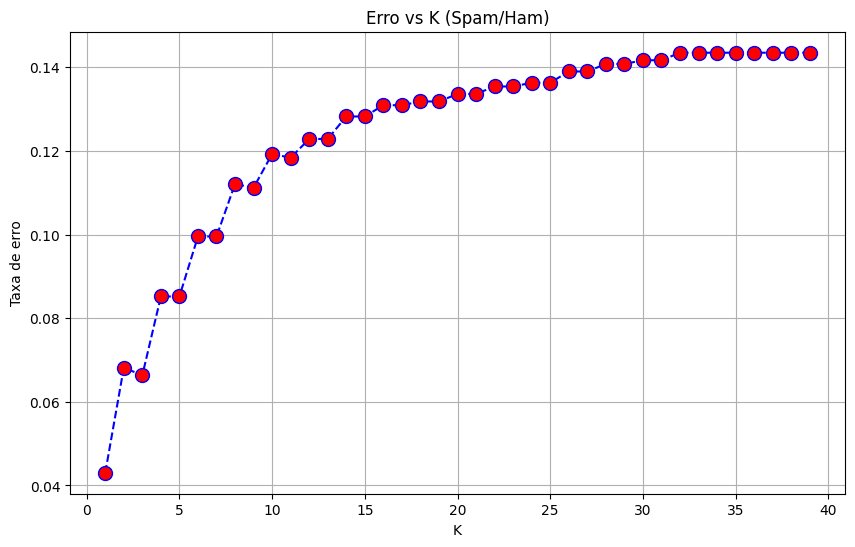

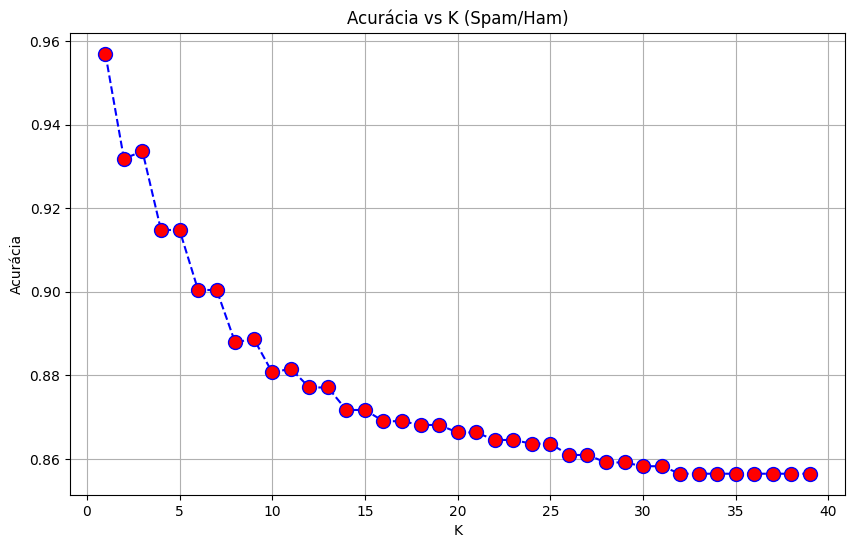

In [ ]:
# KNN - K-Nearest Neighbor
import numpy as np
import matplotlib.pyplot as plt

parametros = {'n_neighbors': [1, 3, 5, 7, 9],
              'weights': ['uniform', 'distance'],
              'metric': ['euclidean', 'manhattan']}

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Aplicando KNN
knn = KNeighborsClassifier()

grid_search = GridSearchCV(estimator=knn, param_grid=parametros, cv=5, scoring='accuracy')
grid_search.fit(X_train_tfidf, y_train)
print("Melhores parâmetros: ", grid_search.best_params_)

melhor_knn = grid_search.best_estimator_
melhor_y_pred = melhor_knn.predict(X_test_tfidf)

acuracia = accuracy_score(y_test, melhor_y_pred)
f1_macro = f1_score(y_test, melhor_y_pred, average='macro')

print(f"Acurácia com os melhores parâmetros: {acuracia}")
print(f"F1 Score (macro) com os melhores parâmetros: {f1_macro}")

# Taxa de erro para k de 1 a 39
error_rate = []
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_tfidf, y_train)
    pred_i = knn.predict(X_test_tfidf)
    error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,40), error_rate, color='blue', linestyle='dashed',
         marker='o', markerfacecolor='red', markersize=10)
plt.title('Erro vs K (Spam/Ham)')
plt.xlabel('K')
plt.ylabel('Taxa de erro')
plt.grid(True)
plt.show()

# Acurácia vs K
acc = []
for i in range(1, 40):
    neigh = KNeighborsClassifier(n_neighbors=i).fit(X_train_tfidf, y_train)
    yhat = neigh.predict(X_test_tfidf)
    acc.append(accuracy_score(y_test, yhat))

plt.figure(figsize=(10,6))
plt.plot(range(1,40), acc, color='blue', linestyle='dashed',
         marker='o', markerfacecolor='red', markersize=10)
plt.title('Acurácia vs K (Spam/Ham)')
plt.xlabel('K')
plt.ylabel('Acurácia')
plt.grid(True)
plt.show()


In [ ]:
# KNN - na mão
import numpy as np
from collections import Counter
from scipy.spatial.distance import euclidean

def distancia_euclidiana(x1, x2):
    # Converte as duas entradas para arrays densos 1D
    return euclidean(x1.toarray().flatten(), x2.toarray().flatten())

def knn(X_train_tfidf, y_train, x_test_tfidf, k=3):
    distancias = []

    for i in range(X_train_tfidf.shape[0]):
        distancia = distancia_euclidiana(x_test_tfidf, X_train_tfidf[i])
        distancias.append((distancia, y_train[i]))

    distancias.sort(key=lambda x: x[0]) # Ordena pela menor distância
    k_neighboors = distancias[:k] # Seleciona os k mais próximos
    classes = [label for _, label in k_neighboors]
    classe_mais_frequente = Counter(classes).most_common(1)

    return classe_mais_frequente[0][0]

def avaliacao_knn(X_train_tfidf, y_train, X_test_tfidf, y_test, k):
    certo = 0
    for i in range(X_test_tfidf.shape[0]):
        pred = knn(X_train_tfidf, y_train, X_test_tfidf[i], k)
        if pred == y_test[i]:
            certo += 1

    acuracia = certo / X_test_tfidf.shape[0]
    print(f"Acurácia com K={k}: {acuracia}")
    return acuracia

avaliacao_knn(X_train_tfidf, y_train, X_test_tfidf, y_test, k=5)

acc = []
for k in range(1, 21):
    print(f"Testando K={k}...")
    acc.append(avaliacao_knn(X_train_tfidf, y_train, X_test_tfidf, y_test, k))

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(range(1,21), acc, color='blue', linestyle='dashed',
         marker='o', markerfacecolor='red', markersize=8)
plt.title('Acurácia do KNN Manual vs K')
plt.xlabel('K')
plt.ylabel('Acurácia')
plt.grid(True)
plt.show()

Acurácia com K=5: 0.9147982062780269
Testando K=1...


In [22]:
# SVM 

from sklearn import svm
from sklearn.model_selection import GridSearchCV

parametros = {
    'C': [0.1, 1, 10],  # Parâmetro C
    'gamma': ['scale', 'auto', 0.1, 1],  # Parâmetro gamma
    'kernel': ['rbf', 'linear']  # Tipos de kernel
}
# Parâmetro C pequeno tolera mais erros (evita overfitting) - está com valor padrão
# Parâmetro gamma pequeno define que cada ponto de treino tem influencia ampla resultando em 
# uma fronteira maior - está com valor padrão

from sklearn.svm import SVC

svc = svm.SVC(probability=True)

grid_search = GridSearchCV(estimator=svc, param_grid=parametros, cv=5, scoring='accuracy')

grid_search.fit(X_train_tfidf, y_train)

print(f"Melhores parâmetros encontrados: {grid_search.best_params_}")

# Fazendo a previsão com os melhores parametros
y_pred = grid_search.best_estimator_.predict(X_test_tfidf)

from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

print(f"Acurácia: {accuracy_score(y_test, y_pred)}")
f1_macro = f1_score(y_test, y_pred, average='macro')
print(f"F1-Score Macro: {f1_macro}")


KeyboardInterrupt: 